In [2]:
import os
import io
import numpy as np
import sklearn as sk
import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import pandas as pd
import collections
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import clear_output
#import graphviz as g

#Model taken from https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/


In [3]:
## Import and prepare data

dfTrain = pd.read_csv('synthetic_data_mutated.csv', header=None)
dfTest = pd.read_csv('test_synthetic_data_mutated.csv', header=None)

#print(dfTrain) #Uncomment to see imported data
#print(len(dfTest.index))

In [4]:
xTrain = dfTrain[[1]]
xTrain.columns = ['sequence']
xTrain.insert(0, 'protein', 'synthetic')
yTrain = dfTrain[[0]]
yTrain.columns = ['tm']

xTest = dfTest[[1]]
xTest.columns = ['sequence']
xTest.insert(0, 'protein', 'synthetic')
yTest = dfTest[[0]]
yTest.columns = ['tm']
 
print(yTrain)

           tm
0      334.55
1      352.55
2      337.55
3      337.75
4      324.65
5      355.15
6      329.85
7      327.15
8      336.15
9      364.00
10     363.45
11     339.85
12     325.25
13     343.15
14     326.00
15     342.35
16     347.45
17     338.65
18     343.85
19     366.95
20     335.85
21     364.15
22     352.65
23     323.65
24     328.00
25     350.05
26     332.15
27     339.15
28     353.00
29     346.05
...       ...
34603  334.00
34604  334.00
34605  334.00
34606  334.00
34607  334.00
34608  334.00
34609  334.00
34610  334.00
34611  334.00
34612  334.00
34613  334.00
34614  334.00
34615  334.00
34616  334.00
34617  334.00
34618  334.00
34619  334.00
34620  334.00
34621  334.00
34622  334.00
34623  334.00
34624  334.00
34625  334.00
34626  334.00
34627  334.00
34628  334.00
34629  334.00
34630  334.00
34631  334.00
34632  334.00

[34633 rows x 1 columns]


In [5]:
POLAR_AMINO_ACIDS = ['D', 'E', 'K', 'R', 'H', 'S', 'T', 'Q', 'N', 'Y']
NON_POLAR_AMINO_ACIDS = ['A', 'V', 'L', 'I', 'M', 'F', 'W']
SPECIAL_AMINO_ACIDS = ['G', 'C', 'P']

POLAR_KEY = "polar"
NON_POLAR_KEY = "nonpolar"
SPECIAL_KEY = "special"

datasetSize = len(xTrain)
doneCount = 0
## Features taken from Ruben's NN model + baseline + others
# Add features to training data
# bigram, unigrams, trigrams, ratios of hydrophobic to hydrophilic, ratios of various amino acids to each other, cysteine location within the sequence - middle veg end
for index, row in xTrain.iterrows():
    clear_output(wait=True)
    sequence = row[1]
    counts = collections.Counter(sequence)
    # Length feature
    xTrain.at[index, 'Length'] = len(sequence)

    # add (E + K)/(Q + H) ratio feature
    if (counts['Q'] + counts['H']) != 0:
        xTrain.at[index, '(E + K)/(Q + H)'] = (counts['E'] + counts['K']) /(counts['Q'] + counts['H'])
    else:
        xTrain.at[index, '(E + K)/(Q + H)'] = 0  
    
    for key in counts.keys():
        # Aminoacid count feature
        xTrain.at[index, "num " + key] = counts[key]
        # Aminoacid presence feature
        xTrain.at[index, "presence " + key] = 1
    
    '''
    #Bigrams feature
    bigramsDict = collections.defaultdict(lambda: 0)
    bigrams = [sequence[i:i+2] for i in range(len(sequence)-2+1)]
    #Populate bigrams dictionary
    for bigram in bigrams:
        bigramsDict[bigram] += 1
    #Add counts as features
    for key in bigramsDict.keys():
        xTrain.at[index, "num " + key] = counts[key]
    #print(bigrams)

    
    #Trigrams feature
    trigramsDict = collections.defaultdict(lambda: 0)
    trigrams = [sequence[i:i+3] for i in range(len(sequence)-3+1)]
    #print(trigrams)
    for trigram in trigrams:
        trigramsDict[trigram] += 1
    #Add counts as features
    for key in trigramsDict.keys():
        xTrain.at[index, "num " + key] = counts[key]
    #print(trigramsDict)
    '''
    
    #Polarity feature
    individual_counts = {
        POLAR_KEY : 0,
        NON_POLAR_KEY : 0,
        SPECIAL_KEY : 0,
    }
    
    for i in range(len(sequence)):
        if sequence[i] in POLAR_AMINO_ACIDS:
            individual_counts[POLAR_KEY] += 1
        elif sequence[i] in NON_POLAR_AMINO_ACIDS:
            individual_counts[NON_POLAR_KEY] += 1
        elif sequence[i] in SPECIAL_AMINO_ACIDS:
            individual_counts[SPECIAL_KEY] += 1

    for key in individual_counts.keys():
        xTrain.at[index, "num " + key] = individual_counts[key]
    
    #print(individual_counts)
    #print("Protein done")
    doneCount += 1
    print("Current progress: ", np.round(doneCount/len(xTrain) * 100, 2), "%")
    
xTrain = xTrain.fillna(0)
#print(xTrain)

#Make a list of all features
featureNames = []
featureValues = {}
for feature in xTrain.columns.tolist()[2:]:
    featureNames.append(feature)
for feature in featureNames:
    featureValues[feature] = xTrain[feature]
    
#print(featureNames)
#print(featureValues['Length'].tolist()) #Uncomment to see features and values for training data

Current progress:  100.0 %


In [6]:
print(len(featureNames))
for featureName in featureNames:
    print(featureName)

47
Length
(E + K)/(Q + H)
num S
presence S
num E
presence E
num K
presence K
num I
presence I
num N
presence N
num D
presence D
num L
presence L
num R
presence R
num Q
presence Q
num G
presence G
num T
presence T
num A
presence A
num Y
presence Y
num H
presence H
num F
presence F
num W
presence W
num V
presence V
num C
presence C
num P
presence P
num M
presence M
num polar
num nonpolar
num special
num X
presence X


In [7]:
# Extract features from sequence
def extractSeqFeatures(sequence, features):
    sequenceDF = pd.DataFrame()
    counts = collections.Counter(sequence)
    # Length feature
    sequenceDF.at[index, 'Length'] = len(sequence)
    
    # add (E + K)/(Q + H) ratio feature
    if (counts['Q'] + counts['H']) != 0:
        sequenceDF.at[index, '(E + K)/(Q + H)'] = (counts['E'] + counts['K']) /(counts['Q'] + counts['H'])
    else:
        sequenceDF.at[index, '(E + K)/(Q + H)'] = 0  
        
    for key in counts.keys():
        # Aminoacid frequency feature
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
        # Aminoacid presence feature
        if "presence " + key in featureNames:
            sequenceDF.at[index, "presence " + key] = 1
    
    
    '''
    #Bigrams feature
    bigramsDict = collections.defaultdict(lambda: 0)
    bigrams = [sequence[i:i+2] for i in range(len(sequence)-2+1)]
    #Populate bigrams dictionary
    for bigram in bigrams:
        bigramsDict[bigram] += 1
    #Add counts as features
    for key in bigramsDict.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
    #print(bigrams)


    #Trigrams feature
    trigramsDict = collections.defaultdict(lambda: 0)
    trigrams = [sequence[i:i+3] for i in range(len(sequence)-3+1)]
    #print(trigrams)
    for trigram in trigrams:
        trigramsDict[trigram] += 1
    #Add counts as features
    for key in trigramsDict.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
    #print(trigramsDict)   
    '''
    
    #Polarity feature
    individual_counts = {
        POLAR_KEY : 0,
        NON_POLAR_KEY : 0,
        SPECIAL_KEY : 0,
    }

    for aminoacid in range(len(sequence)):
        if sequence[aminoacid] in POLAR_AMINO_ACIDS:
            individual_counts[POLAR_KEY] += 1
        elif sequence[aminoacid] in NON_POLAR_AMINO_ACIDS:
            individual_counts[NON_POLAR_KEY] += 1
        elif sequence[aminoacid] in SPECIAL_AMINO_ACIDS:
            individual_counts[SPECIAL_KEY] += 1

    for key in individual_counts.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = individual_counts[key]
    
    
    # Fill out features not found
    for name in featureNames:
        if name not in sequenceDF.columns.values:
            sequenceDF.at[index, name] = 0.0
            
    sequenceDF = sequenceDF.fillna(0)
    return sequenceDF    

In [8]:
print(extractSeqFeatures('AXYSYX', featureNames))
count = 0
for colTitle in extractSeqFeatures('AXYSYX', featureNames).columns.tolist():
    print(colTitle)
    

       Length  (E + K)/(Q + H)  num A  presence A  num X  presence X  num Y  \
34632     6.0              0.0    1.0         1.0    2.0         1.0    2.0   

       presence Y  num S  presence S  ...  num W  presence W  num V  \
34632         1.0    1.0         1.0  ...    0.0         0.0    0.0   

       presence V  num C  presence C  num P  presence P  num M  presence M  
34632         0.0    0.0         0.0    0.0         0.0    0.0         0.0  

[1 rows x 47 columns]
Length
(E + K)/(Q + H)
num A
presence A
num X
presence X
num Y
presence Y
num S
presence S
num polar
num nonpolar
num special
num E
presence E
num K
presence K
num I
presence I
num N
presence N
num D
presence D
num L
presence L
num R
presence R
num Q
presence Q
num G
presence G
num T
presence T
num H
presence H
num F
presence F
num W
presence W
num V
presence V
num C
presence C
num P
presence P
num M
presence M


In [9]:
from sklearn.tree import DecisionTreeRegressor

# Create tree
rTree = DecisionTreeRegressor(criterion='mse')

# Make list of training features data
XTrainFeatures = []
for row in xTrain.iterrows():
    index, data = row
    XTrainFeatures.append(data.tolist()[2:]) # Starting from 2 so that name and sequence not in list

print(XTrainFeatures[0])

YTrainTargets = yTrain

print("Training Tree...")
# Fit tree according to features
rTree = rTree.fit(XTrainFeatures, YTrainTargets)
print("Done Training Tree.")

#print(XTrainFeatures)
prediction = rTree.predict([XTrainFeatures[8]])

# Update testing dataset
XTestFeatures = []
#print(xTest)
for row in xTest.iterrows():
    index, data = row
    sequence = data[1]
    featuresDF = extractSeqFeatures(sequence, featureNames)
    XTestFeatures.append(featuresDF.values.tolist())
    
# Update testing dataset
XTrainFeats = []
#print(xTest)
for row in xTrain.iterrows():
    index, data = row
    sequence = data[1]
    featuresDF = extractSeqFeatures(sequence, featureNames)
    XTrainFeats.append(featuresDF.values.tolist())
    
y_Pred_Train = []
for data in XTrainFeats:
    prediction_Tm = rTree.predict(data)
    y_Pred_Train.append(prediction_Tm[0])

y_Pred_Test = []
for data in XTestFeatures:
    prediction_Tm = rTree.predict(data)
    y_Pred_Test.append(prediction_Tm[0])



[233.0, 2.1666666666666665, 12.0, 1.0, 15.0, 1.0, 24.0, 1.0, 10.0, 1.0, 19.0, 1.0, 17.0, 1.0, 23.0, 1.0, 7.0, 1.0, 12.0, 1.0, 15.0, 1.0, 17.0, 1.0, 7.0, 1.0, 18.0, 1.0, 6.0, 1.0, 8.0, 1.0, 2.0, 1.0, 13.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 147.0, 65.0, 21.0, 0.0, 0.0]
Training Tree...
Done Training Tree.


ValueError: invalid literal for int() with base 10: 'tm'

In [41]:
from sklearn.metrics import r2_score
yTrainList = [int(i) for i in yTrain['tm']]
#print(yTrainList)
yTrainPredList = [int(i) for i in y_Pred_Train]
yTestList =[int(i) for i in yTest['tm']]
yTestPredList = [int(i) for i in y_Pred_Test]
#print(yTrainList)
#print(yTrainPredList)
print(yTestList)
print(yPredList)
print("Train set accuracy is: ", r2_score(yTrainList, yTrainPredList))
print("Test set accuracy is: ",r2_score(yTestList, yTestPredList))


[325, 336, 342, 358, 333, 328, 332, 321, 339, 351, 326, 343, 324, 358, 327, 363, 342, 332, 330, 342, 326, 327, 330, 330, 323, 346, 330, 336, 335, 340, 324, 333, 349, 361, 324, 338, 338, 344, 339, 332, 335, 343, 333, 343, 359, 348, 330, 329, 333, 327, 338, 327, 338, 330, 325, 342, 360]
[363.15000000000003, 330.05, 337.1499999999995, 362.150000000001, 338.6500000000007, 345.150000000001, 353.94999999999794, 366.0, 320.14999999999725, 334.55000000000115, 363.1500000000004, 349.15000000000026, 334.0500000000019, 325.15000000000083, 363.44999999999993, 364.0, 322.3499999999998, 343.55000000000194, 345.150000000001, 336.14999999999696, 325.15000000000083, 353.25, 353.94999999999794, 360.575, 352.275, 349.15000000000026, 339.3499999999997, 326.0, 353.94999999999794, 322.44999999999925, 353.0, 321.44999999999874, 321.44999999999874, 320.94999999999993, 355.1500000000008, 325.25, 343.3500000000036, 353.94999999999794, 334.15000000000094, 360.575, 351.1499999999975, 360.575, 337.1499999999995, 3

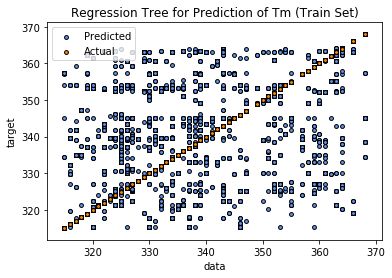

In [43]:
import random
# Plot training set results
fig = plt.figure(edgecolor='black')
#print(df['protein'].tolist())
ax1 = plt.scatter(yTrainList, y_Pred_Train, edgecolor="black",
            c="cornflowerblue", s= 15, label="Predicted")
ax2 = plt.scatter(yTrainList, yTrainList, s=15, edgecolor="black",
            c="darkorange", label="Actual")

#print(XTrainFeatures)
#print(y_Pred)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Regression Tree for Prediction of Tm (Train Set)")
plt.legend()
plt.show()
ax1.set_facecolor('tab:blue')
ax2.set_facecolor('tab:blue')
fig.set_facecolor('tab:blue')

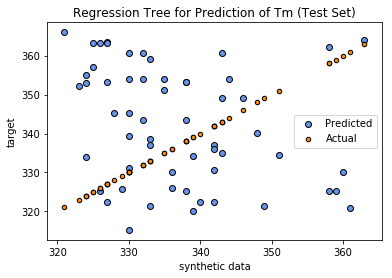

In [45]:
import random
# Plot testing set results
y = plt.figure()
#print(df['protein'].tolist())
plt.scatter(yTestList, y_Pred_Test, edgecolor="black",
            c="cornflowerblue", label="Predicted")
plt.scatter(yTestList, yTestList, s=20, edgecolor="black",
            c="darkorange", label="Actual")

#print(XTrainFeatures)
#print(y_Pred)
plt.xlabel("synthetic data")
plt.ylabel("target")
plt.title("Regression Tree for Prediction of Tm (Test Set)")
plt.legend()
plt.show()